In [1]:
from itertools import product
from typing import Dict, List, Any

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from IOData.IOData import InputRule

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType, ControllerTypes
from tools.simualtion_results import Results
from tools.simple_track_generator import trackGenerator

In [2]:
save_fig = False

simualte_type = 'TRACK_SIMULATE'

Simulator = {
    # 'SINGLE_CURVATURE'  : SingleCurvatureSimulator,
    'TRACK_SIMULATE'    : TrackSimulator,
}.get(simualte_type)

simulator = Simulator()
simulator.a_d_max = 2
simulator.delta_d_max = 0.12
simulator.use_saved_data = False
simulator.save_data = True
simulator.simulate_model_type = ModelType.DYNAMIC_WITH_L
simulator.data_model_type = ModelType.DYNAMIC_WITH_L
simulator.filter_model_type = ModelType.DYNAMIC_WITH_L
simulator.t_sim = 12.0
simulator.num_predicted_traj = 10
simulator.global_initial_state = np.array([0.0, 0.0, 0.0, 0.3, 0.0, 0.0])
simulator.cur = 1/1.0
simulator.track_fun_name = 'oval_track'
simulator.lag = 10
simulator.save_predicted_traj = True
simulator.save_dataset_after = True
simulator.delete_dataset_after = True
simulator.v_x_max = 2.7
# simulator.v_x_max = 2.3

simulator.t_data = 2.5
t_collection = 18.0
# t_new_data = simulator.t_data * 0.6
t_new_data = np.inf
simulator.data_input_rule = InputRule.PRBS_TIMES_RANDOM_MEAN

# simulator.n_v_max = 0
simulator.n_x, simulator.n_y, simulator.n_psi, simulator.n_v = 0,0,0,0
simulator.n_e_lat_max, simulator.n_mu_max, simulator.n_v_max, simulator.n_l_max = 0,0,0,0 # for test of prediction error

random_seed = 1
track_filter_type = TrackFilterTypes.SINGLE_SEGMENT
filter_type = SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L
application_filter_type = ControllerTypes.INDIRECT_FIX_MU_MAX_L

L_filter = 65
L_controller = 80
    
filter_param: List[Dict[str, Any]] = {
    # SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING: [
    #     {'lam_sig': 50000, 'L': 80, 'R': np.matrix('1,0;0,1'),
    #     'c': [[0.25, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
    #     'min_dist': 0.1, 'min_num_slices': int(0.45*simulator.t_data/simulator.Ts), 'min_portion_slices': 0.4, 'f': lambda x: 1/(1.1*x)**2},
    # ],
    SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L: [
        {'lam_sig': 2000, 'L': L_filter, 'R': np.matrix('1,0;0,1'),
        'c': [[0.1, 0.05, 0.05, 0.01], [0.1, 0.05, 0.05, 0.01], [0.1, 0.05, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': np.inf, 'min_num_slices': int(0.5*simulator.t_data/simulator.Ts), 'min_portion_slices': 0.4, 'f': lambda x: 1/(1.1*x)**2,
        'solver': cp.OSQP,
        'solver_args': {
            'warm_starting': False,
            'max_iter': 5e4,
            'eps_prim_inf': 1e-3,
            'eps_dual_inf': 1e-3,
        },
        # 'solver': cp.MOSEK,
        # 'solver_args': {'mosek_params':{
        #     'MSK_DPAR_INTPNT_CO_TOL_PFEAS':1e-3,
        #     'MSK_DPAR_INTPNT_CO_TOL_DFEAS':1e-3,
        #     'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':1e-3,
        #     'MSK_DPAR_INTPNT_CO_TOL_INFEAS':1e-2,
        #     'MSK_IPAR_INTPNT_MAX_ITERATIONS': 100000}}
        },
    ],
    ControllerTypes.INDIRECT_FIX_MU_MAX_L: [
        {'lam_sig': 10, 'L': L_controller, 'R': np.matrix('1,0;0,1'),
        'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': np.inf,
        'min_num_slices': int(0.45*simulator.t_data/simulator.Ts),
        'min_portion_slices': 0.1,
        # 'f': lambda x: 1/(1.1*x)**2,
        'f': lambda x: 1,
        # 'f': lambda x: np.exp(-x**2),
        # 'f': lambda x: np.exp(-x**2) + 8,
        'use_zero_l_initial': True,
        'verbose': False,
        'solver': None,
        'solver_args': {}
        },

        {'lam_sig': 10, 'L': L_controller, 'R': np.matrix('1,0;0,1'),
        'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': 15.0,
        'min_num_slices': 150,
        'min_portion_slices': 0.01,
        # 'f': lambda x: 1/(1.1*x)**2,
        'f': lambda x: 1,
        # 'f': lambda x: np.exp(-x**2),
        # 'f': lambda x: np.exp(-x**2) + 5,
        'use_zero_l_initial': True,
        'verbose': False,
        'solver': None,
        'solver_args': {}
        },

        {'lam_sig': 10, 'L': L_controller, 'R': np.matrix('1,0;0,1'),
        'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': 15.0,
        'min_num_slices': 150,
        'min_portion_slices': 0.01,
        # 'f': lambda x: 1/(1.1*x)**2,
        # 'f': lambda x: 1,
        # 'f': lambda x: np.exp(-x**2),
        'f': lambda x: np.exp(-x**2) + 5,
        'use_zero_l_initial': True,
        'verbose': False,
        'solver': None,
        'solver_args': {}
        },
    ],
    }
simulation_input_rules = [
    SimulationInputRule.SINE_WITH_MEAN,
    # SimulationInputRule.MAX_THROTTLE,
    # SimulationInputRule.MAX_THROTTLE_SINE_STEER,
    ]
collection_rule = SimulationInputRule.SINE_WITH_MEAN_RANDOM

list_results_list_list = []
for collection_params in filter_param[filter_type]:
    results_list = simulator.simulate_with_separate_collection(random_seed, track_filter_type, filter_type, application_filter_type, collection_params, filter_param[application_filter_type], collection_rule, simulation_input_rules, 8, continue_to_end=True, stop_after_out_of_track_collection=False, t_collection = t_collection, random_seed_collection=random_seed+1)
    list_results_list_list.append(results_list)


Running with initial dataset

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [250], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': inf, 'min_num_slices': 112, 'min_portion_slices': 0.1, 'f': <function <lambda> at 0x11c3fbee0>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}
Constraint not satisfied at time 0.38.
Constraint satisfied again at time 4.59.
Constraint not satisfied at time 4.98.
vehicle moved to segment 1!
Constraint satisfied again at time 5.41.
Constraint not satisfied at time 6.0.
Constraint satisfied again at time 6.99.
vehicle moved to segment 2!
Constraint not satisfied at time 7.59.


At t = 0.00722923, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results


At t = 0.00840354, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results


At t = 0.000788593, mxstep steps taken before reaching tout.


Exception Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. raised during system simulation, returning partial results
And with first dataset list [250], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': 15.0, 'min_num_slices': 150, 'min_portion_slices': 0.01, 'f': <function <lambda> at 0x11c42c8b0>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}
Constraint not satisfied at time 0.38.


At t = 0.00712384, mxstep steps taken before reaching tout.


Exception Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. raised during system simulation, returning partial results
And with first dataset list [250], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': 15.0, 'min_num_slices': 150, 'min_portion_slices': 0.01, 'f': <function <lambda> at 0x11c42d280>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}
Constraint not satisfied at time 0.38.


At t = 0.00711996, mxstep steps taken before reaching tout.


Exception Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. raised during system simulation, returning partial results


Simulating with input rule SimulationInputRule.RANDOM_WITH_MEAN
And with first dataset list [250]
vehicle moved to segment 1!
vehicle moved to segment 2!
Constraint not satisfied at time 3.97.
Constraint satisfied again at time 4.18.
Constraint not satisfied at time 5.12.
Constraint satisfied again at time 5.25.
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
Constraint not satisfied at time 16.28.
Constraint satisfied again at time 16.54.
vehicle moved to segment 4!

Continue to simulate

Simulating with i

At t = 0.00480939, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results


And with first dataset list [250, 212, 128]
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!

Continue to simulate

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [250, 212, 128, 160, 120, 76], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0

At t = 0.000396721, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
And with first dataset list [250, 212, 128, 160, 120, 76], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': 15.0, 'min_num_slices': 150, 'min_portion_slices': 0.01, 'f': <function <lambda> at 0x11c42c8b0>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}


At t = 0.0027046, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!
And with first dataset list [250, 212, 128, 160, 120, 76], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': 15.0, 'min_num_slices': 150, 'min_portion_slices': 0.01, 'f': <function <lambda> at 0x11c42d280>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}


At t = 0.00127706, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!


At t = 0.00467009, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results
vehicle moved to segment 1!


And with first dataset list [250, 212, 128, 160, 120, 76]
Constraint not satisfied at time 0.58.
Constraint satisfied again at time 0.67.
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!

Continue to simulate

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [250, 212, 128, 160, 120, 76, 168, 128, 40], and application parameters {'lam_sig'

At t = 0.00882707, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results
vehicle moved to segment 4!
vehicle moved to segment 0!
And with first dataset list [250, 212, 128, 160, 120, 76, 168, 128, 40], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': 15.0, 'min_num_slices': 150, 'min_portion_slices': 0.01, 'f': <function <lambda> at 0x11c42c8b0>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}
vehicle moved to segment 1!
Constraint not satisfied at time 2.0100000000000002.
Constraint satisfied agai

At t = 0.00823057, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results
And with first dataset list [250, 212, 128, 160, 120, 76, 168, 128, 40, 160, 124, 56], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': 15.0, 'min_num_slices': 150, 'min_portion_slices': 0.01, 'f': <function <lambda> at 0x11c42c8b0>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}
Constraint not satisfied at time 0.46.
Constraint satisfied again at time 0.62.
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle move

At t = 0.00263119, mxstep steps taken before reaching tout.


Constraint satisfied again at time 11.61.
And with first dataset list [250, 212, 128, 160, 120, 76, 168, 128, 40, 160, 124, 56, 156, 120, 72, 164, 120, 68, 156, 120, 84, 160, 120, 76], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1, 0],
        [0, 1]]), 'c': [[0.2, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.15, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': inf, 'min_dist': 15.0, 'min_num_slices': 150, 'min_portion_slices': 0.01, 'f': <function <lambda> at 0x11c42c8b0>, 'use_zero_l_initial': True, 'verbose': False, 'solver': None, 'solver_args': {}}
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!
vehicle moved to segment 2!
And with first dataset list [250, 212, 128, 160, 120, 76, 168, 128, 40, 160, 124, 56, 156, 120, 72, 164, 120, 68, 156, 120, 84, 160, 120, 76], and application parameters {'lam_sig': 10, 'L': 80, 'R': matrix([[1,

9


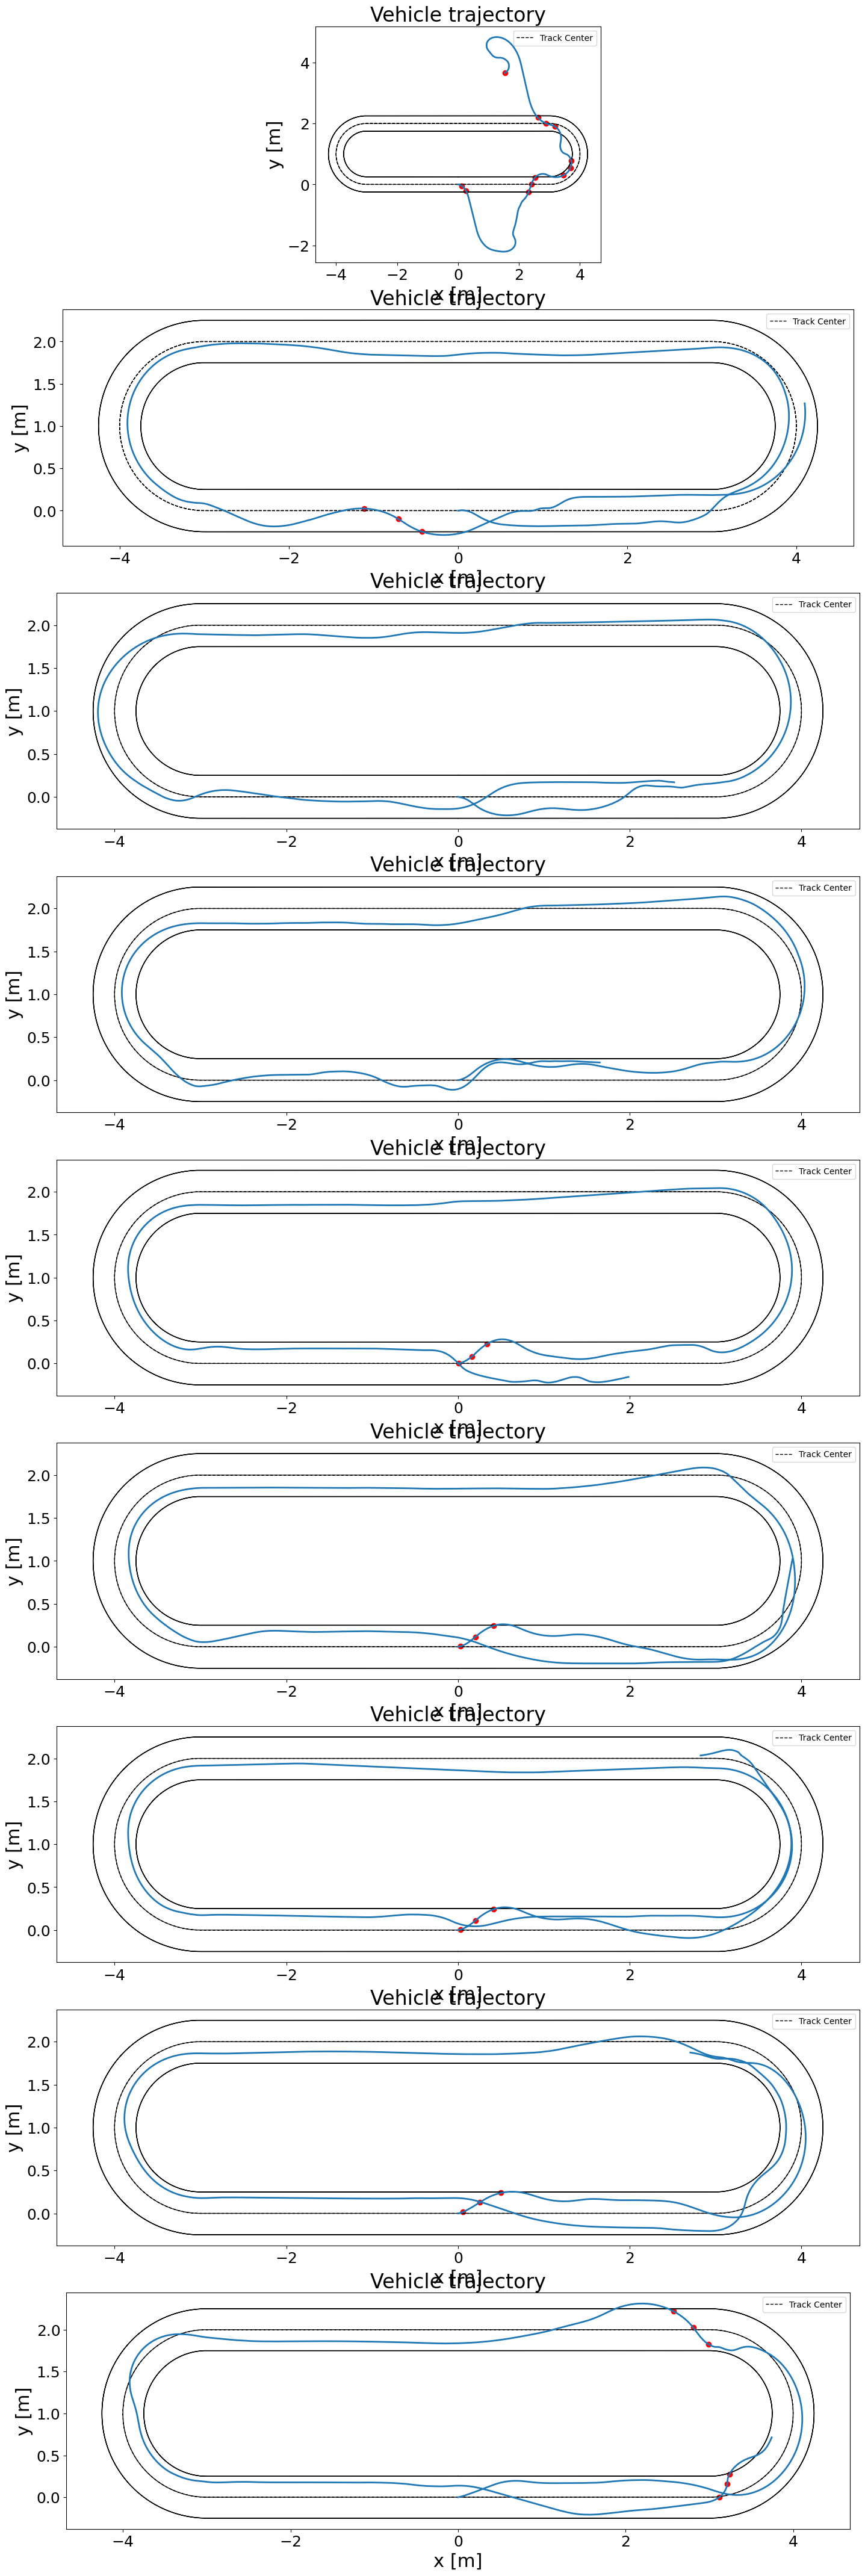

In [64]:
results_list: List[Results] = list_results_list_list[0][1]
print(len(results_list))
# plot global trajectory and track
# n_cols, n_rows = int((len(results_list))/(len(simulation_input_rules)+1)), len(simulation_input_rules)+1
n_cols, n_rows = 1, len(results_list)
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False, figsize=(18*n_cols,6*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        results = results_list[i+j*n_rows]
        if results is not None:
            results.plot_vehicle_trajectory(ax=axs[i,j], gen=simulator.track_generator, plot_marked_steps=True)
plt.show()
if save_fig:
    fig.savefig('fig/track_simulation.pdf', bbox_inches='tight')

In [106]:
i_seg_to_reach = 3
for results in results_list[-5:]:
    indices_at_seg_to_reach = np.nonzero(np.array(results._segment_index_list) == i_seg_to_reach)[0]
    print(results.Ts*indices_at_seg_to_reach[0])
    # print(results._error_trajectory[indices_at_seg_to_reach[-1]][2])

print('-------------------')
for results in results_list[-5:]:
    indices_at_seg_to_reach = np.nonzero(np.array(results._segment_index_list) == i_seg_to_reach)[0]
    # print(results.Ts*indices_at_seg_to_reach[0])
    print(results._error_trajectory[indices_at_seg_to_reach[0]][2])

6.12
5.8
5.4
5.8
6.44
-------------------
2.380051843578463
2.3732307031978417
2.301681333380224
2.3689675435141533
2.4096945494789024


In [78]:
results_list: List[Results] = list_results_list_list[0][1]
print(len(results_list))
for results in results_list:
    # print(results.average_intervention)
    # results.calculate_lap_time()
    print(results.violating_time)

print('lap time')
for results in results_list:
    results.calculate_lap_time()
    print(results.lap_time)

9
9.690000000000001
0.23000000000000043
0.0
0.0
0.23000000000000004
0.12999999999999995
0.14999999999999997
0.06999999999999995
0.5599999999999987
lap time
0.0
8.92
10.040000000000001
10.16
8.84
8.6
8.16
8.36
9.36


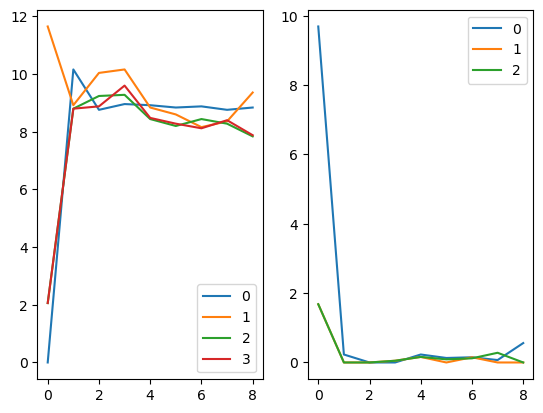

In [44]:
fig, ax = plt.subplots(1,2)
ax = plt.subplot(1,2,1)
for i, results_list in enumerate(list_results_list_list[0]):
    time_list = []
    for results in results_list:
        if results.lap_time > 0:
            time_list.append(results.lap_time)
        else:
            time_list.append(results.simulation_time)
    ax.plot(time_list, label=i)
ax.legend()
ax = plt.subplot(1,2,2)
for i, results_list in enumerate(list_results_list_list[0][1:]):
    time_list = []
    for results in results_list:
        if results.violating_time > 0:
            time_list.append(results.violating_time)
        else:
            time_list.append(0)
    ax.plot(time_list, label=i)
ax.legend()

In [36]:
import datetime
import os
import pickle
time = f"{datetime.datetime.now():%m-%d_%H_%M}"
file_name = time + "-" + "results_list" + ".pkl"
with open(os.path.join(os.getcwd(), 'datasets', file_name), 'wb') as file:
    pickle.dump(results_list, file)

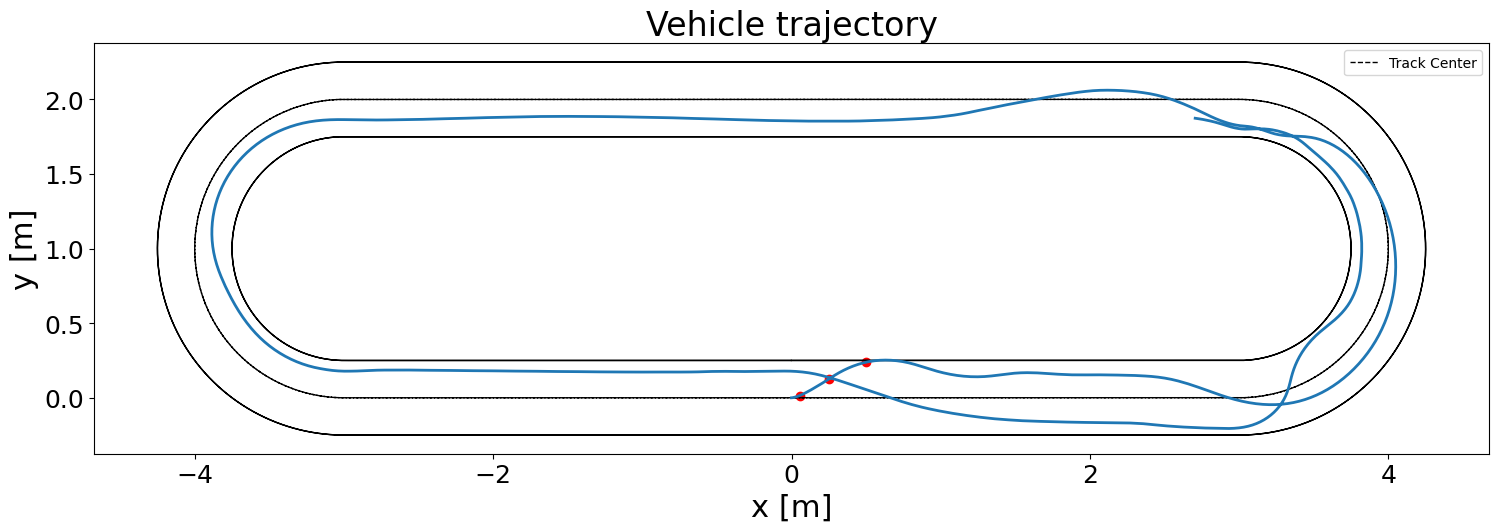

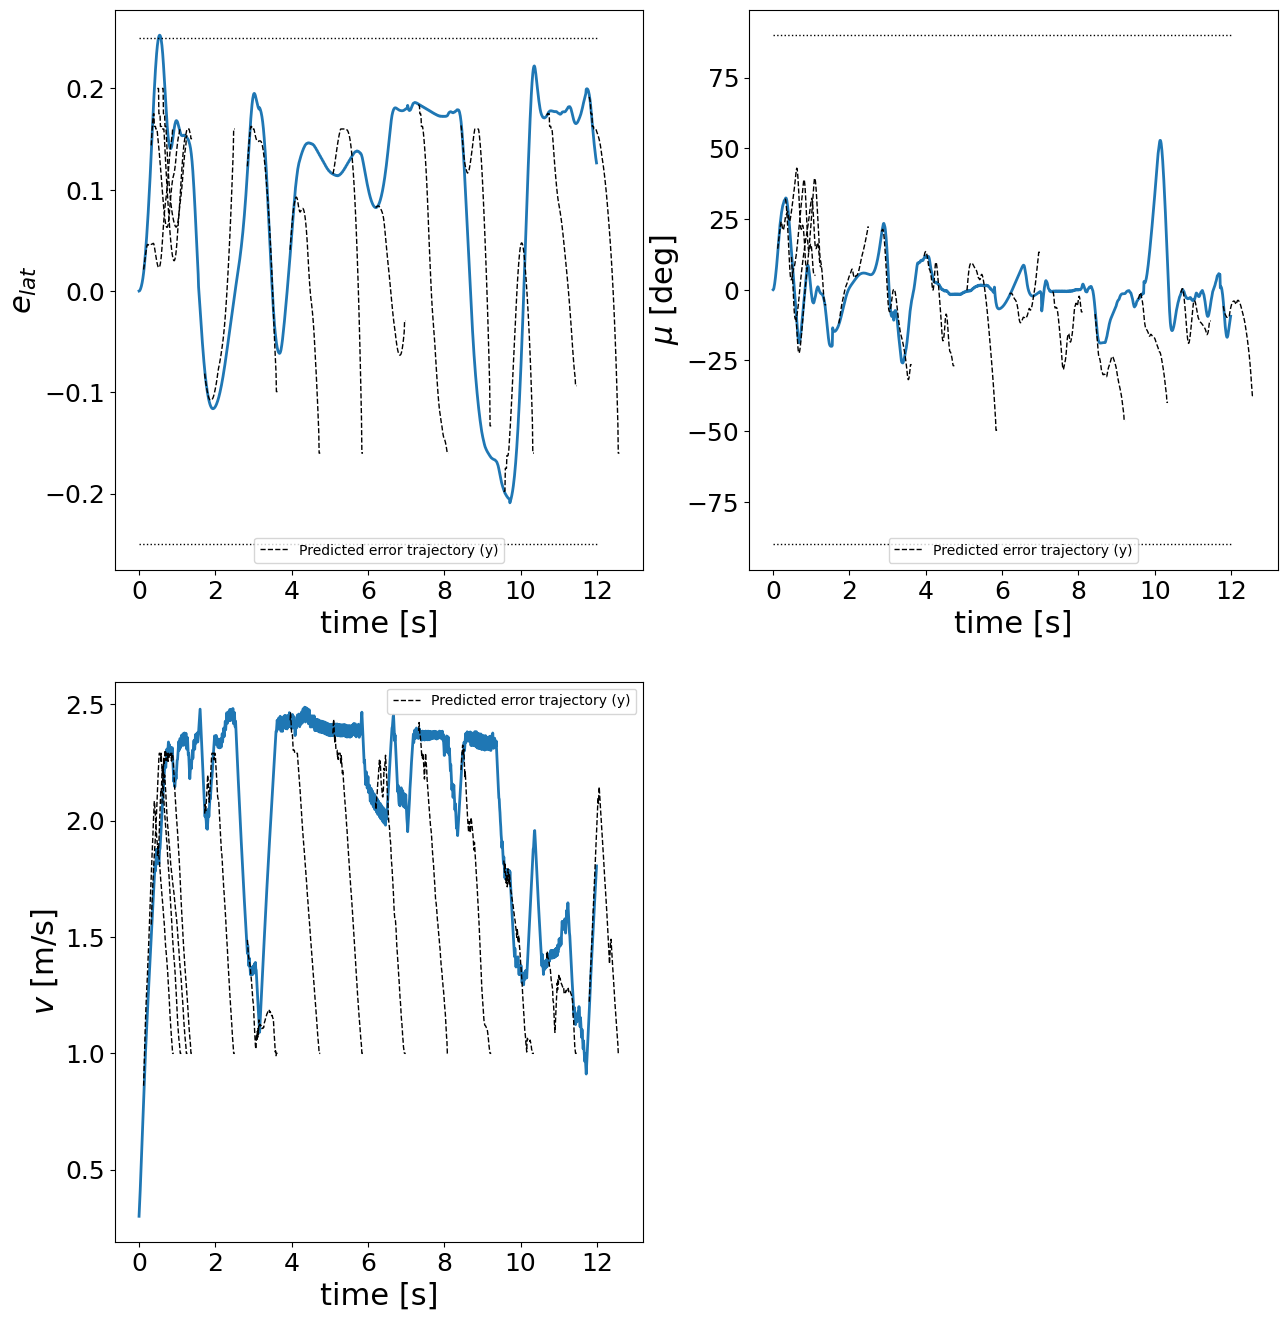

In [92]:
# choose one result to plot details
results = list_results_list_list[0][1][-1]
# results = dict_results[(random_seed, track_filter_types[0], SafetyFilterTypes.INDIRECT_ZERO_V, simulation_input_rules[0])][0]
fig, ax = plt.subplots(figsize=(18,6))
results.plot_vehicle_trajectory(ax=ax, gen=simulator.track_generator, plot_marked_steps=True)
plt.savefig('fig/track-simulation-single-trajectory.pdf', bbox_inches='tight')

# plot given error dynamics trajectory
plt.figure(figsize=(15,16))
#velocity input
ax = plt.subplot(221)
results.plot_error_trajectory(0, ax, constraint=(-simulator.track_width/2, simulator.track_width/2))
results.plot_predicted_error_slices(0, ax)
ax = plt.subplot(222)
results.plot_error_trajectory(1, ax, constraint=(simulator.mu_min*180/np.pi, simulator.mu_max*180/np.pi))
results.plot_predicted_error_slices(1, ax)
ax = plt.subplot(223)
results.plot_error_trajectory(2, ax)
results.plot_predicted_error_slices(2, ax)
plt.show()

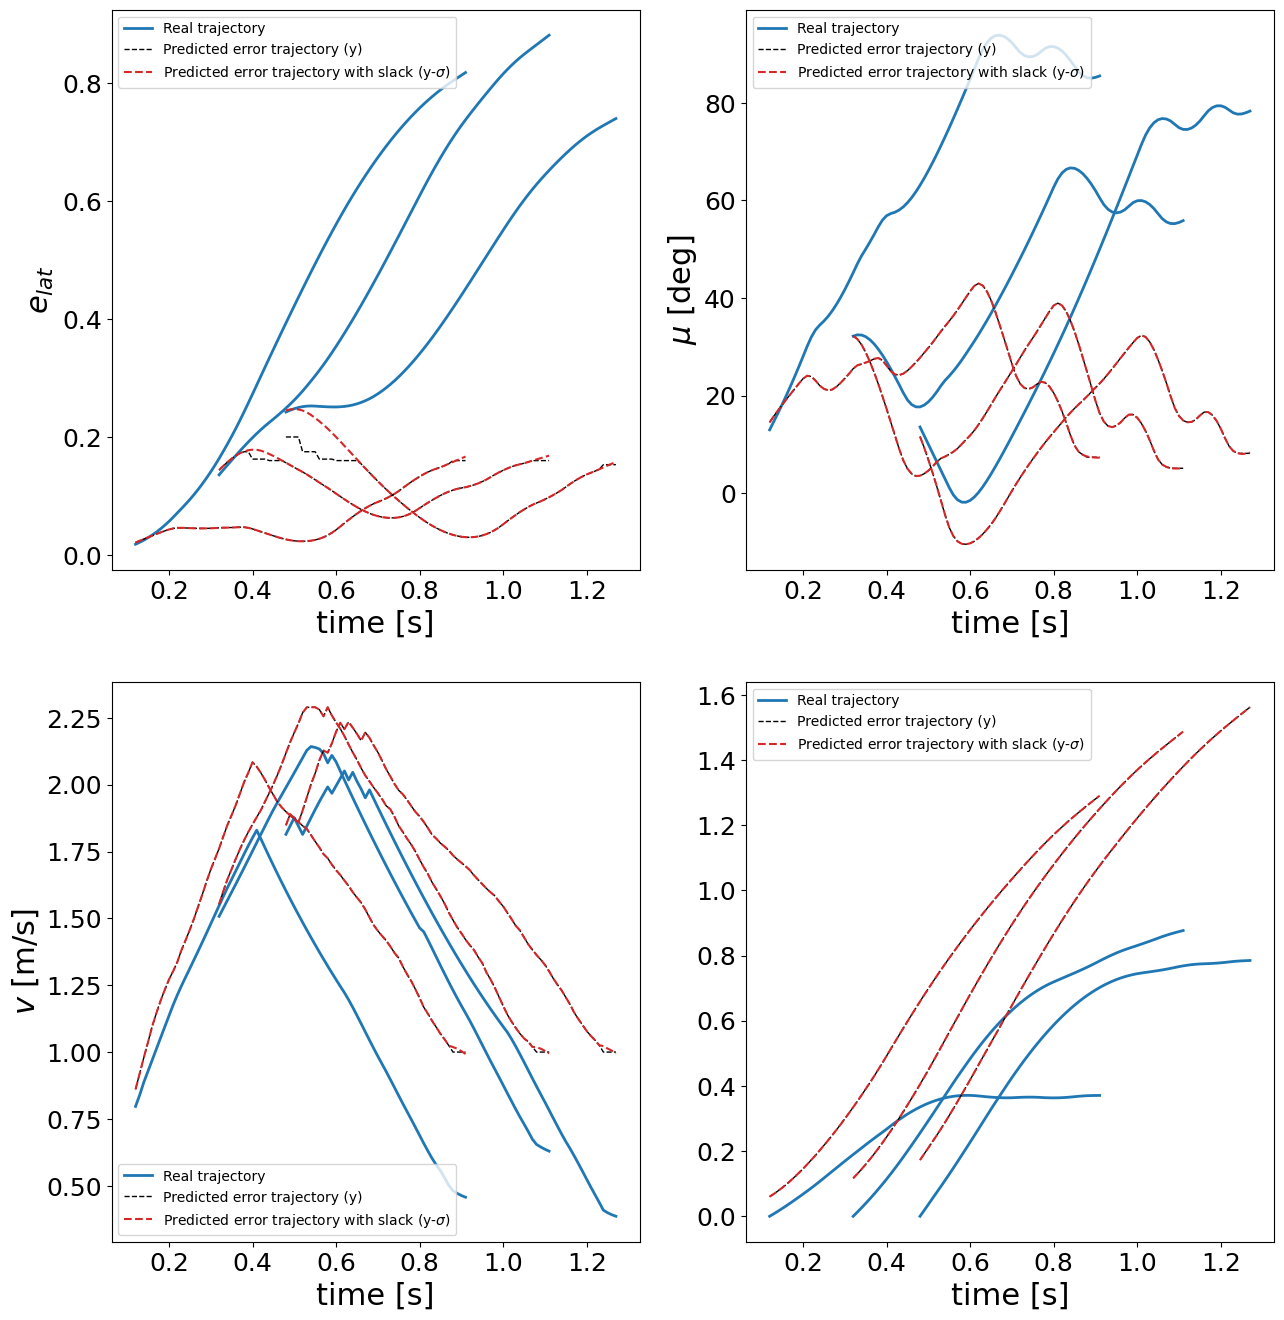

(5,)


In [93]:
# plot given predicted trajectory and real trajectory
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(15,16))
#velocity input
ax = plt.subplot(221)
time_spans = [(t-0.5, t) for t in results.violating_time_steps[0:1]]
# results.plot_error_trajectory(0, ax, constraint=(-simulator.track_width/2, simulator.track_width/2))
results.plot_error_slices(0, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(0, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(0, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
ax = plt.subplot(222)
# results.plot_error_trajectory(1, ax, constraint=(simulator.mu_min*180/np.pi, simulator.mu_max*180/np.pi))
results.plot_error_slices(1, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(1, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(1, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
ax = plt.subplot(223)
# results.plot_error_trajectory(2, ax)
results.plot_error_slices(2, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(2, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(2, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
ax = plt.subplot(224)
# results.plot_error_trajectory(2, ax)
results.plot_error_slices(4, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(4, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(4, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
plt.show()
print(results._error_trajectory_slices[0][1][0].shape)

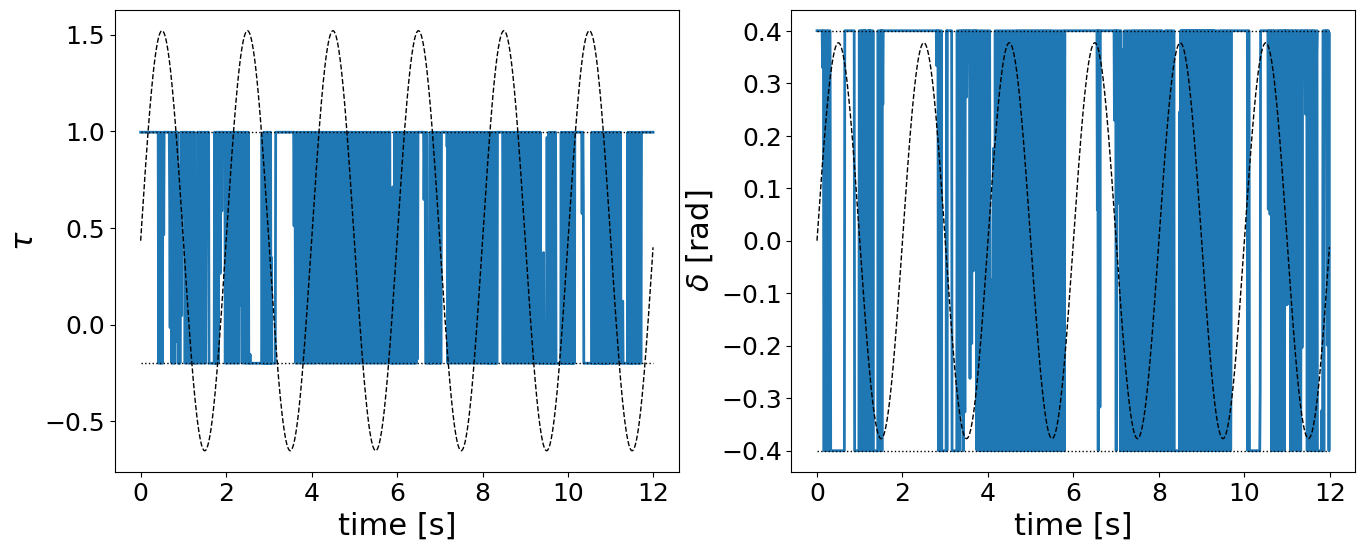

In [94]:
# plot given and applied inputs
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
results.plot_input_applied(0, ax, constraint=(simulator.a_min*simulator.m, simulator.a_max*simulator.m))
results.plot_input_obj(0, ax)
ax = plt.subplot(122)
results.plot_input_applied(1, ax, constraint=(-simulator.delta_max, simulator.delta_max))
results.plot_input_obj(1, ax)
# plt.show(block=True)
plt.savefig('fig/track_simulation_inputs.pdf', bbox_inches='tight')

In [95]:
sigma_max = results.calculate_sigma_infty_value()
print(sigma_max)

(0.010737068358879887, 1557.3417329811807)


In [96]:
sigma_max[1]/np.pi*180

89229.10855941125

In [97]:
def plot_average_itervention(ax: plt.Axes, results: Dict[TrackFilterTypes, Results]) -> plt.Axes:
    """Plot the average intervention for the input corresponds to the input."""
    width = 0.3 # width of bar

    x = np.arange(len(results))
    input_names = ['Torque', 'steering']

    offset = -width/2
    rects = ax.bar(x + offset, [round(result.average_intervention[0],2) for result in results.values()], width, label=input_names[0], color='tab:blue')
    ax.bar_label(rects, padding=3)
    ax.set_ylim(0, 1.5)
    ax.set_ylabel('Torque Intervention')
    ax.legend(loc='upper left', ncols=2)

    ax = ax.twinx()  # instantiate a second axes that shares the same x-axis
    offset = width/2
    rects = ax.bar(x + offset, [round(result.average_intervention[1],2) for result in results.values()], width, label=input_names[1], color='tab:red', hatch='///')
    ax.bar_label(rects, padding=3)
    ax.set_ylim(0, 0.5)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Steering Intervention')
    ax.set_title('MSR Input Intervention for Different Terminal Ingredients')
    ax.set_xticks(x, [key.value for key in results.keys()])
    ax.legend(loc='upper right', ncols=2)
    

In [98]:
results_dict_filter_types = {
    key[2]: result_list[0] for key, result_list in dict_results.items()
}
print(results_dict_filter_types)
fig, ax = plt.subplots(layout='constrained')

ax = plot_average_itervention(ax, results_dict_filter_types)

NameError: name 'dict_results' is not defined

In [ ]:
io_data = simulator.io_data_dict[1/0.5]

plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [y[0,0] for y in io_data._output_data])

KeyError: 2.0

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [y[1,0]*180/np.pi for y in io_data._output_data])

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [y[2,0] for y in io_data._output_data])

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [u[0,0] for u in io_data._input_data])

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [u[1,0] for u in io_data._input_data])

In [ ]:
error_list = []
for predicted_traj, real_traj in zip(results._predicted_error_with_slack_slices, results._error_trajectory_slices):
    predicted_traj = predicted_traj[1] # extract trajectory
    real_traj = real_traj[1] # extract trajectory
    for predicted_state, real_state in zip(predicted_traj[:], real_traj[:]):
        error_list.append(predicted_state - real_state)

In [ ]:
np.sqrt(np.sum([error[0]**2 for error in error_list])/len(error_list))

In [ ]:
i = 2
# print(simulator.systems[i].cur)
io_data_list = simulator.filter._safety_filters[i]._io_data_list
for io_data in io_data_list:
    print(len(io_data._input_data))

In [ ]:
import os
import pickle
# # curvature, sample time, [list of time length of io_datas]
# with open(os.path.join(os.getcwd(), 'datasets', f'io_data_random_2.0_0.01_160_240.pkl'), 'wb') as file:
#                         pickle.dump(io_data_list, file)

In [ ]:
results.mean_calculation_time

In [ ]:
print(len(simulator.buffer_u_value[0][1]))
print(simulator.buffer_u_value[0][1][0])
print(len(simulator.buffer_y_value[0][1]))
print(simulator.buffer_y_value[0][1][0])


In [ ]:
# from scipy.spatial import ConvexHull, Voronoi
# H_uy = results.H_uy
# H_uy = np.array(H_uy.T)

# vor = Voronoi(H_uy)
# cov_hull = ConvexHull(H_uy)